# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, H. Janati, M. Massias

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22nd of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "bryan"
ln1 = "chen"
fn2 = "alice"
ln2 = "devilder"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_chen_bryan_and_devilder_alice.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [9]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

C:\Users\alice\AppData\Local\Temp\ipykernel_26592\428856815.py:4: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [10]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [15]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += A[:, j].dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:, j] * (w[j] - old_w_j)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= gradient[j] / lips_const[j]
        # update gradient:
        gradient += gram[:, j] * (w[j] - old_w_j)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

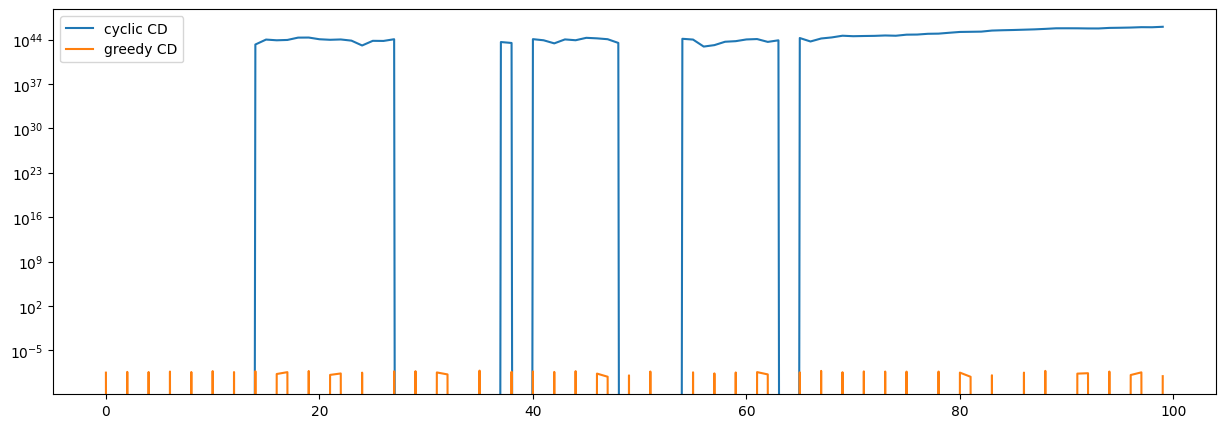

In [26]:
# compute precise minimum with your favorite solver

from numpy.linalg import lstsq

w_min, _, _, _ = lstsq(A, b, rcond=None)

# print(w_min)

n_iter = 3000
w_cyclic, all_objs_cyclic = cyclic_cd(A, b, n_iter)
w_greedy, all_objs_greedy = greedy_cd(A, b, n_iter)

plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
plt.plot(w_cyclic-w_min, label='cyclic CD')
plt.plot(w_greedy-w_min, label='greedy CD')
plt.yscale('log')
plt.legend()

# plt.subplot(1, 2, 2)
# plt.stem(w_min, label='True weights')
# plt.stem(w_cyclic, label='Estimated weights (cyclic CD)')
# plt.stem(w_greedy, label='Estimated weights (greedy CD)')
# plt.legend()

plt.show()

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: 
</div>

$$
\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0
, \text{where }\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}
$$

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$
\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) 
$$

where $\times$ is the Cartesian product between sets,
and 
$$ 
\partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

To show that $\hat w = 0_p$ is the unique minimizer if and only if $\lambda \geq \lambda_{\max} := \frac{1}{2}\|X^\top y\|_\infty$, we'll utilize subgradient optimality conditions for convex functions.

**Step 1: Express the Objective Function**

The optimization problem is:

$$
\hat w \in \operatorname*{arg\,min}_{w \in \mathbb{R}^p} \left[ f(w) + \lambda \|w\|_1 \right],
$$

where:

$$
f(w) = \sum_{i=1}^{n} \log\left(1 + e^{-y_i w^\top x_i}\right).
$$

**Step 2: Compute the Gradient of $f(w)$ at $w = 0_p$**

The gradient of $f(w)$ with respect to $w$ is:

$$
\nabla f(w) = -\sum_{i=1}^{n} y_i x_i \frac{e^{-y_i w^\top x_i}}{1 + e^{-y_i w^\top x_i}} = -\sum_{i=1}^{n} y_i x_i \sigma(-y_i w^\top x_i),
$$

where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.

At $w = 0_p$:

$$
\nabla f(0_p) = -\sum_{i=1}^{n} y_i x_i \left( \frac{1}{2} \right) = -\frac{1}{2} X^\top y.
$$

**Step 3: Write the Subgradient Optimality Condition**

The subdifferential of the $L_1$-norm at $w = 0_p$ is:

$$
\partial \|w\|_1 \Big|_{w=0_p} = [-1, 1]^p.
$$

The subgradient optimality condition is:

$$
0 \in \nabla f(0_p) + \lambda \partial \|w\|_1 \Big|_{w=0_p}.
$$

Plugging in the values:

$$
0 \in -\frac{1}{2} X^\top y + \lambda s, \quad \text{where } s \in [-1, 1]^p.
$$

**Step 4: Derive the Condition for $\hat w = 0_p$ Being Optimal**

Rewriting the optimality condition:

$$
\frac{1}{2} X^\top y \in \lambda s, \quad s \in [-1, 1]^p.
$$

This implies:

$$
\left| \frac{1}{2} X^\top y \right| \leq \lambda,
$$

where the absolute value is taken component-wise. Therefore:

$$
\lambda \geq \frac{1}{2} \|X^\top y\|_\infty = \lambda_{\max}.
$$

**Conclusion**

- If $\lambda \geq \lambda_{\max}$, then $\hat w = 0_p$ satisfies the optimality condition and is the unique minimizer.
- Conversely, if $\hat w = 0_p$ is the unique minimizer, the optimality condition must hold, implying $\lambda \geq \lambda_{\max}$.

**Therefore:**

$$
\lambda \geq \lambda_{\max} \quad \Leftrightarrow \quad \hat w = 0_p.
$$

---

**Answer:**

**Solution:**

We use subgradient optimality conditions for convex functions.

1. Compute the gradient of the loss at $w = 0$:

$$
\nabla f(0) = -\tfrac{1}{2} X^\top y.
$$

2. At $w = 0$, the subdifferential of the $L_1$ norm is $\partial\|w\|_1|_{w=0} = [-1,1]^p$.

3. Optimality requires:

$$
0 \in -\tfrac{1}{2} X^\top y + \lambda\, \partial\|w\|_1|_{w=0}.
$$

4. This holds if and only if $\lambda \geq \tfrac{1}{2}\|X^\top y\|_\infty = \lambda_{\max}$.

Thus, $\lambda \geq \lambda_{\max} \iff \hat{w} = 0\`.


<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

*answer here*

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [6]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    # lips_const = 
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            # grad_j = 
            # w[j] = soft_thresh(1, 2)
            
            # if old_w_j != w[j]:
                # Xw += 
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [7]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:311: UserWarning: Multiple active versions of the dataset matching the name leukemia exist. Versions may be fundamentally different, returning version 1.
  warn(
c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [8]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).